# Project 2 - Reuters 딥러닝 모델

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [15]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=2023)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


In [16]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
    one_hot = np.zeros((len(data), dim))
    
    for i, d in enumerate(data):
        one_hot[i, d] = 1.
        
    return one_hot

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

In [17]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(x_train.shape[1], )))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(y_train.shape[1], activation='softmax'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1280128   
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_5 (Activation)    (None, 128)              

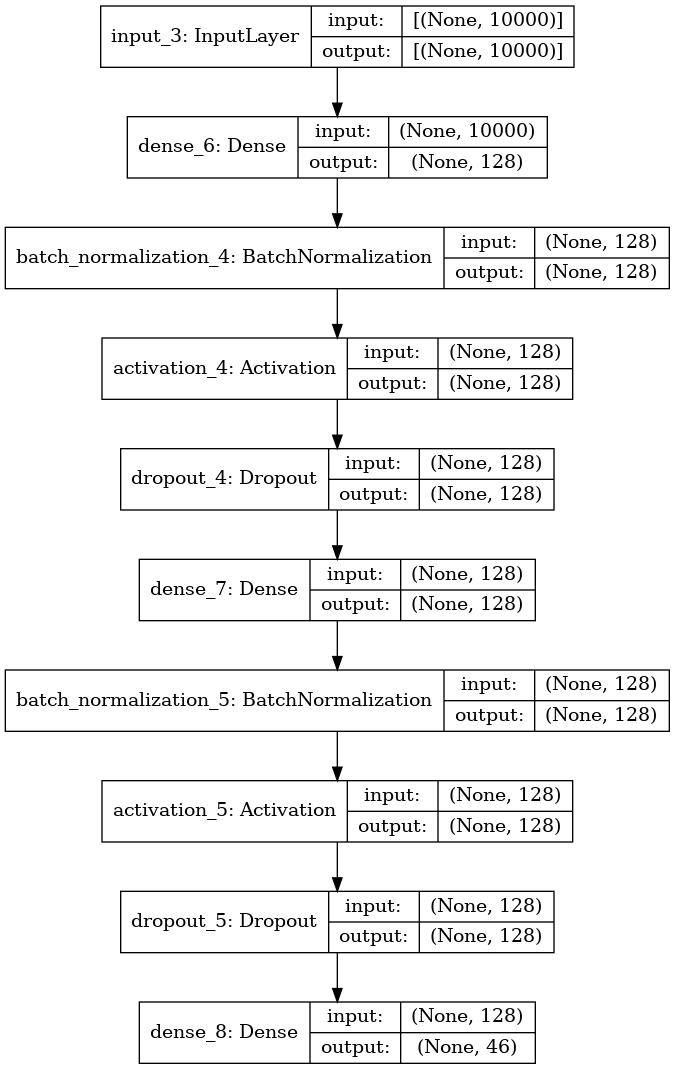

In [18]:
model.summary()
utils.plot_model(model, show_shapes=True)

In [19]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

check_point_cb = callbacks.ModelCheckpoint('reuters_model.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=60,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
211/211 [==============================] - 2s 7ms/step - loss: 1.9059 - accuracy: 0.5730 - val_loss: 1.4195 - val_accuracy: 0.7155
Epoch 2/60
211/211 [==============================] - 1s 5ms/step - loss: 1.3108 - accuracy: 0.6973 - val_loss: 1.1453 - val_accuracy: 0.7569
Epoch 3/60
211/211 [==============================] - 1s 5ms/step - loss: 1.1004 - accuracy: 0.7405 - val_loss: 1.1000 - val_accuracy: 0.7801
Epoch 4/60
211/211 [==============================] - 1s 5ms/step - loss: 0.9811 - accuracy: 0.7727 - val_loss: 1.0806 - val_accuracy: 0.7872
Epoch 5/60
211/211 [==============================] - 1s 6ms/step - loss: 0.8958 - accuracy: 0.7926 - val_loss: 1.0850 - val_accuracy: 0.7894
Epoch 6/60
211/211 [==============================] - 1s 5ms/step - loss: 0.8145 - accuracy: 0.8082 - val_loss: 1.0978 - val_accuracy: 0.7939
Epoch 7/60
211/211 [==============================] - 1s 5ms/step - loss: 0.8004 - accuracy: 0.8175 - val_loss: 1.1298 - val_accuracy: 0.8019
Epoch 

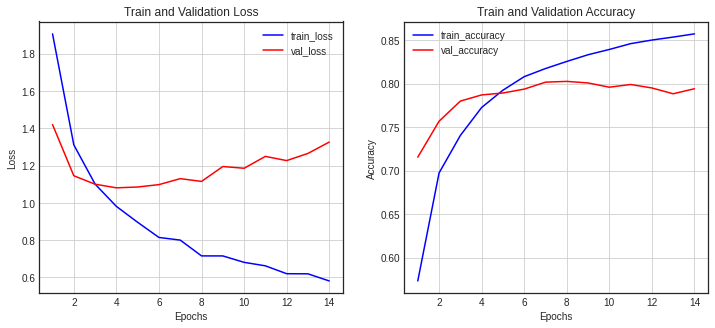

In [20]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [21]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 1.1631 - accuracy: 0.7654


[1.1631479263305664, 0.7653606534004211]